In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import os
import copy
import numpy as np
import time

cudnn.benchmark = True # 최적의 backend 연산을 찾는 flag를 true 로 설정
plt.ion()   # 대화형 모드

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU 사용가능 여부 확인. cuda가 설정되어 있으면 연산을 gpu로 하고, 아니면 cpu
device

device(type='cuda', index=0)

In [ ]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체를 train, val 별로 지정
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),# 이미지 resize 
        transforms.RandomResizedCrop(224), # 이미지를 랜덤으로 자르기
        transforms.RandomHorizontalFlip(p=0.5),# 데이터 증진(augmentation)
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(180),
        transforms.ToTensor(), # 데이터를 tensor로 바꿔준다. 넘파이는 정수값이 들어있어 오차율 가늠이 힘들고 CIDA 연산도 지원하지 않음
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 정규화(normalization)작업에 쓰일 각 채널의 표준값과 표준편차값, PyTorch 기본값으로 셋팅
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_dir = './data_new' # 이미지 데이터셋에 상단의 transform 내용 적용

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes
     

In [ ]:
# train과 valid 데이터 개수 확인
print(len(image_datasets['train']), len(image_datasets['val']), len(image_datasets['test']))

64000 8000 8000


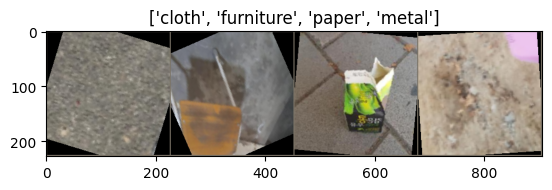

In [ ]:
import matplotlib.pyplot as plt # 데이터 시각화

def imshow(inp, title=None):
    # torch.Tensor를 numpy 객체로 변환
    inp = inp.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    # 이미지 출력
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes]) #  batch size만큼의 image, label이 출력
     

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25): # 모델학습 함수
    since = time.time()

    loss_history = {'train': [], 'val': [], 'test': []}
    metric_history = {'train': [], 'val': [], 'test': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):  # 에폭마다 for문을 넣어주고
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습단계와 테스트 단계를 거쳐서 진행
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            elif phase == 'val':
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # 아웃풋 설정
                    _, preds = torch.max(outputs, 1) # 인풋에 대현 예측값
                    loss = criterion(outputs, labels) # 예측값과 실제 결과값 비교

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward() # 역전파
                        optimizer.step() # 최적화(optimizer 스텝 증가) 

                # 통계
                running_loss += loss.item() * inputs.size(0) # 교차엔트로피 계산. deafualt값이 mean이므로 각 데이터 마다의 손실 평균이 저장, 배치 사이즈를 곱해줘 한 배치 사이즈의 loss 총합을 계산
                running_corrects += torch.sum(preds == labels.data) # 예측값이 맞은 횟수 더하기
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase] # 에폭에 따른 loss, accuracy 계산 (전체 데이터 loss합/ 각 데이터셋 크기)
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 

            print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}') # loss, accuracy 출력

            if phase == 'train':
                loss_history['train'].append(epoch_loss)
                metric_history['train'].append(epoch_acc)
            elif phass == 'val ':
                loss_history['val'].append(epoch_loss)
                metric_history['val'].append(epoch_acc)

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc: # best_acc, weight 값 저장
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since       # 반복할 때마다 현재 - 기존 시간 계산해 걸린 시간 표시
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Accuracy: {best_acc:4f}')

    # 제일 잘 나온 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [ ]:
def visualize_model(model, num_images=15): # 시각화 함수
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # 모델에 나온 값
            _, preds = torch.max(outputs, 1) # 예측값

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}') #예측값만 출력
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training) # 앞에서 선언한 값에 넣기
                    return
        model.train(mode=was_training)

In [ ]:
from torch.optim import lr_scheduler # 미세조정 (무작위 초기화가 아닌, 미리 학습한 신경망으로 초기화한다)

model_ft = models.vgg16(pretrained=True) # False가 되면 모델의 구조만 가져오고 초깃값은 랜덤 설정

num_ftrs = model_ft .classifier[6].in_features # 6계층 배열인 model.classifier를 사용
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names)) 

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 곱해서 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
summary(model_ft, (3,32,32)) # 모델 정보 확인

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [ ]:
model_ft, loss_hist, metric_hist = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10) 

Epoch 0/9
----------
train Loss: 1.2628 Accuracy: 0.5977
val Loss: 0.7953 Accuracy: 0.7444
test Loss: 0.8054 Accuracy: 0.7385

Epoch 1/9
----------
train Loss: 0.9765 Accuracy: 0.6879
val Loss: 0.7204 Accuracy: 0.7678
test Loss: 0.7088 Accuracy: 0.7734

Epoch 2/9
----------
train Loss: 0.8772 Accuracy: 0.7208
val Loss: 0.7662 Accuracy: 0.7595
test Loss: 0.7656 Accuracy: 0.7624

Epoch 3/9
----------
train Loss: 0.8159 Accuracy: 0.7398
val Loss: 0.5629 Accuracy: 0.8146
test Loss: 0.5511 Accuracy: 0.8206

Epoch 4/9
----------
train Loss: 0.7744 Accuracy: 0.7516
val Loss: 0.6062 Accuracy: 0.8015
test Loss: 0.5989 Accuracy: 0.8097

Epoch 5/9
----------
train Loss: 0.7425 Accuracy: 0.7615
val Loss: 0.5221 Accuracy: 0.8294
test Loss: 0.5207 Accuracy: 0.8306

Epoch 6/9
----------
train Loss: 0.7254 Accuracy: 0.7673
val Loss: 0.5327 Accuracy: 0.8313
test Loss: 0.5338 Accuracy: 0.8269

Epoch 7/9
----------
train Loss: 0.5048 Accuracy: 0.8367
val Loss: 0.3561 Accuracy: 0.8826
test Loss: 0.3563 Ac

ValueError: num must be an integer with 1 <= num <= 14, not 15

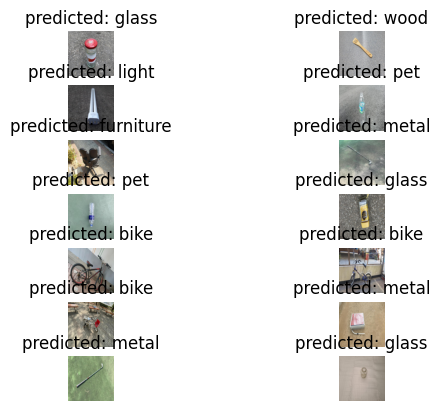

In [ ]:
visualize_model(model_ft) # 예측값 시각화 

In [ ]:
model_path = os.path.join('./data_new', str('model_vgg16_fine')+".pth") # 모델저장
torch.save(model_ft.state_dict(), model_path)

In [ ]:
train_loss_history = loss_hist["train"] # 그래프로 표시
val_loss_history = loss_hist["val"]
train_acc_history = metric_hist["train"]
val_acc_history = metric_hist["val"]

train_acc_history = torch.stack(train_acc_history).cpu() # 리스트가 파이토치 텐서라 1차원 텐서로 바꿔주고 gpu 텐서는 넘파이 변환이 안되므로 cpu로..
val_acc_history =  torch.stack(val_acc_history).cpu()

plt.title("Train-Val Loss")
plt.plot(train_loss_history,label="train")
plt.plot(val_loss_history,label="val")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(train_acc_history,label="train")
plt.plot(val_acc_history,label="val")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()